In [ ]:
%load_ext autoreload

In [ ]:
import asyncio
import operator
import os
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path
from pprint import pprint
from typing import Annotated, Literal, TypedDict

import dspy
from dspy import InputField, OutputField, Predict, Signature
from IPython.display import Image, Markdown, display
from langchain.tools import tool
from langchain_core.documents import Document
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_core.runnables import RunnableConfig
from langchain_tavily import TavilySearch
from langgraph.graph import END, MessagesState, StateGraph
from langgraph.graph.message import add_messages
from langgraph.types import Send
from langsmith import traceable
from loguru import logger
from pydantic import BaseModel, Field

from config import config
from data_processing import (
    load_and_process_csv,
    load_documents_from_csv,
    split_documents,
)
from embeddings import initialize_embeddings
from evaluation import (
    RAGEvaluator,
    evaluate_rag_pipeline,
    generate_test_dataset,
)
from formatting import format_messages
from prompts import (
    context,
    initial_research_prompt,
    report_organization,
    scratchpad_prompt,
    section_writer_prompt,
)
from rag_chain import RAGOutput
from retrieval import build_retriever
from retrieval_formatter import RetrieverReportGenerator
from source_formatter import SourceFormatter
from utils import print_separator, setup_environment

# dspy.configure_cache(enable_disk_cache=False, enable_memory_cache=False)

In [ ]:
# from pubmed_scraper import PubMedScraper

# scraper = PubMedScraper(email = "olandechris@gmail.com")

# df = scraper.search_with_llm(query = "find me 50 papers about covid 19 from 2019 to 2025 by anthony fauci")

In [ ]:
def prepare_data(input_csv: str, output_csv: str | Path | None = None) -> Path:
    """
    Prepare and process the input data.

    Args:
        input_csv: Path to input CSV file
        output_csv: Path to save processed CSV (optional)

    Returns:
        Path to the processed CSV file
    """
    print_separator("DATA PREPARATION")
    if output_csv is None:
        output_csv = Path(config.paths.data_dir) / "tests.csv"

    # Load and process CSV
    print(f"Loading data from {input_csv}")
    df = load_and_process_csv(input_csv, output_csv)

    return Path(output_csv)

In [ ]:
def build_rag_system(csv_path: str):
    """
    Build the complete RAG system.

    Args:
        csv_path: Path to processed CSV file

    Returns:
        Tuple of (rag_chain, splitted_documents, embeddings)
    """
    print_separator("BUILDING RAG SYSTEM")
    print("Initializing Embeddings ...")

    embeddings = initialize_embeddings(
        model_name=config.model.embedding_model,
        cache_dir=config.model.embedding_cache_dir,
    )

    # Load and split the documents
    print("Loading documents...")
    documents = load_documents_from_csv(csv_path)

    print("Splitting documents...")
    splitted_documents = split_documents(documents, embeddings)
    print(f"Created {len(splitted_documents)} document chunks")

    # Build Retriever
    print("Building retriever")
    retriever = build_retriever(splitted_documents, embeddings, config.retriever)

    # Initialize RAG Chain
    print("Initializing RAG Chain ...")

    # Initialize RAG chain
    print("Initializing RAG chain...")
    rag_chain = RAGOutput(
        prompt_name="rlm/rag-prompt:latest",
        retriever=retriever,
        llm_model=config.model.deepseek_model,
    )
    rag_chain.create_chain()

    print("RAG system built successfully")
    return rag_chain, splitted_documents, embeddings

In [ ]:
def run_evaluation(
    rag_chain: RAGOutput,
    test_dataset_path: str | Path | None = None,
    results_path: str | Path | None = None,
):
    """
    Run evaluation on the RAG system.

    Args:
        rag_chain: Configured RAG chain
        test_dataset_path: Path to test dataset (optional)
        results_path: Path to save results (optional)
    """
    print_separator("EVALUATION")

    if test_dataset_path is None:
        test_dataset_path = config.paths.rag_eval_dir / "generated_testset.csv"

    if results_path is None:
        results_path = config.paths.rag_eval_dir / "results_deepseek_fastembed.csv"

    # Run evaluation
    results = evaluate_rag_pipeline(
        rag_chain=rag_chain,
        input_csv_path=str(test_dataset_path),
        output_csv_path=str(results_path),
        question_column="user_input",
    )

    print(f"Evaluation complete. Results shape: {results.shape}")
    return results

In [ ]:
def generate_synthetic_testset(
    splitted_documents, embeddings, llm, testset_size: int = 10
):
    """
    Generate synthetic test dataset using RAGAS.

    Args:
        splitted_documents: Split documents
        embeddings: Embeddings model
        llm: Language model
        testset_size: Number of test samples

    Returns:
        Generated test dataset as DataFrame
    """
    print_separator("GENERATING TEST DATASET")

    output_path = config.paths.rag_eval_dir / "generated_testset.csv"

    dataset = generate_test_dataset(
        documents=splitted_documents,
        embeddings=embeddings,
        llm=llm,
        testset_size=testset_size,
        output_path=str(output_path),
    )

    print(f"Test dataset generated with {len(dataset)} samples")
    return dataset

In [ ]:
def run_full_evaluation(embeddings):
    """
    Run comprehensive evaluation using RAGEvaluator.

    Args:
        embeddings: Embeddings model to use for evaluation

    Returns:
        Dictionary of evaluation results for all model pairs
    """
    print_separator("COMPREHENSIVE EVALUATION")

    # Initialize evaluator
    evaluator = RAGEvaluator(
        max_workers=1,
        timeout=180,
        generative_models=["deepseek-chat"],
        embedding_models=["fastembed"],
    )

    # Run evaluation for all model pairs
    results = evaluator.evaluate_all_models(
        evaluation_embeddings=embeddings, results_dir=str(config.paths.rag_eval_dir)
    )

    # Print summary
    print_separator("EVALUATION SUMMARY")
    for model_pair, df in results.items():
        print(f"\n{model_pair}:")
        print(f"  Shape: {df.shape}")
        if len(df) > 0:
            metric_cols = [
                col
                for col in df.columns
                if col
                not in ["user_input", "reference", "response", "retrieved_contexts"]
            ]
            if metric_cols:
                print(f"  Metrics: {', '.join(metric_cols)}")
                for col in metric_cols:
                    if df[col].dtype in ["float64", "int64"]:
                        print(f"    {col}: {df[col].mean():.4f} (avg)")

    return results

# Program Entry

In [ ]:
# Setup environment
setup_environment()

# Initialize configuration
print_separator("INITIALIZING")
print(f"Data directory: {config.paths.data_dir}")
print(f"RAG evaluation directory: {config.paths.rag_eval_dir}")

llm = config.initialize_llm()
dspy_lm = config.initialize_dspy()
# Prepare data
csv_path = prepare_data("data/gaza_war_impact_children.csv")

# Build RAG system
rag_chain, splitted_documents, embeddings = build_rag_system(str(csv_path))

# Generate test dataset
# generate_synthetic_testset(splitted_documents, embeddings, llm, testset_size=10)

# Run evaluation
# results = run_evaluation(rag_chain)

# eval_results = run_full_evaluation(embeddings)


================================= INITIALIZING =================================

Data directory: data
RAG evaluation directory: RAGEvaluation

=============================== DATA PREPARATION ===============================

Loading data from data/gaza_war_impact_children.csv
Saved processed data to data/tests.csv

============================= BUILDING RAG SYSTEM =============================

Initializing Embeddings ...
Loading documents...
Splitting documents...
Created 24 document chunks
Building retriever
Loading existing FAISS index from faiss_index
Initializing RAG Chain ...
Initializing RAG chain...
RAG system built successfully


# Iteration II

In [ ]:
csv_path = prepare_data("data/gaza_war_impact_children.csv")
#  Load and split the documents
print("Loading documents...")
documents = load_documents_from_csv(csv_path)

print("Splitting documents...")
splitted_documents = split_documents(documents, embeddings)
print(f"Created {len(splitted_documents)} document chunks")

# Build Retriever
print("Building retriever")
retriever = build_retriever(splitted_documents, embeddings, config.retriever)


=============================== DATA PREPARATION ===============================

Loading data from data/gaza_war_impact_children.csv
Saved processed data to data/tests.csv
Loading documents...
Splitting documents...
Created 24 document chunks
Building retriever
Loading existing FAISS index from faiss_index


In [ ]:
def deduplicate_documents(documents: list[list[Document]]):
    seen = set()
    unique_docs = []

    for doc_list in documents:
        for doc in doc_list:
            if doc.page_content not in seen:
                seen.add(doc.page_content)
                unique_docs.append(doc)

    return unique_docs

In [ ]:
class MultiQueryGenerator(Signature):
    """
    Generate multiple natural language queries that explore different aspects of the topic.

    Purpose:
        - Create conversational search queries a person would actually type
        - Each query should explore a different angle or aspect of the topic
        - Maintain natural phrasing - write like a human, not a keyword list
        - Optimize for semantic search engines that understand natural language

    Guidelines:
        - Write complete, natural questions or statements
        - Each query should focus on a different aspect (e.g., history, impact, comparison)
        - Avoid keyword stuffing or robotic phrasing
        - Keep queries conversational and readable
        - Ensure semantic diversity while staying on topic

    Example:
        Input: "Impact of Gaza war on children"
        Output:
            - "How has the Gaza war affected children's mental health and education?"
            - "What are the statistics on child casualties in the Gaza conflict?"
            - "Medical care challenges for pediatric patients during Gaza conflict"

    Example:
        Input: "Kurt Cobain is the best grunge artist ever"
        Output:
            - "Why is Kurt Cobain considered influential in the grunge movement?"
            - "How does Nirvana compare to other grunge bands like Pearl Jam and Soundgarden?"
            - "What was Kurt Cobain's impact on alternative rock music?"
    """

    question = InputField(
        desc="Original user query to rephrase into different perspectives"
    )
    num_queries: int = InputField(
        desc="Number of distinct queries to generate (each exploring a different angle)"
    )

    search_queries: list[str] = OutputField(
        desc="List of natural, conversational queries exploring different aspects of the topic"
    )

In [ ]:
query_optimizer = Predict(MultiQueryGenerator)
response = query_optimizer(
    question="Kurt Cobain is the best grunge artist ever", num_queries=3
)
response.search_queries

["What made Kurt Cobain's songwriting and vocal style so unique in the grunge scene?",
 "How did Nirvana's success with 'Nevermind' change the mainstream music landscape in the early 1990s?",
 "In what ways did Kurt Cobain's public persona and struggles influence his legacy and music?"]

In [ ]:
dspy_lm.inspect_history()





[2025-10-14T18:27:50.975647]

System message:

Your input fields are:
1. `question` (str): Original user query to rephrase into different perspectives
2. `num_queries` (int): Number of distinct queries to generate (each exploring a different angle)
Your output fields are:
1. `search_queries` (list[str]): List of natural, conversational queries exploring different aspects of the topic
All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## question ## ]]
{question}

[[ ## num_queries ## ]]
{num_queries}

[[ ## search_queries ## ]]
{search_queries}        # note: the value you produce must adhere to the JSON schema: {"type": "array", "items": {"type": "string"}}

[[ ## completed ## ]]
In adhering to this structure, your objective is: 
        Generate multiple natural language queries that explore different aspects of the topic.
        
        Purpose:
            - Create conversational search queries a person would actually type
   

In [ ]:
@traceable(name="Multiquery Generator")
def generate_queries(question: str, num_queries: int = 1):
    if not question.strip():
        logger.error("Empty query provided")
        return [question]

    try:
        query_optimizer = Predict(MultiQueryGenerator)
        return query_optimizer(
            question=question, num_queries=num_queries
        ).search_queries
    except Exception as e:
        logger.error(f"An error occurred during query generation: {str(e)}")
        return [question]


test_question = "Impact of the Gaza war on children"
generate_queries(question=test_question)

["How has the Gaza war affected children's mental health, education, and daily life?"]

In [ ]:
@tool
async def retriever_tool(search_query: str):
    """
    Retrieves pubmed data using the provided query and generates a report in markdown format.
    """
    try:
        report_gen = RetrieverReportGenerator()
        result = await retriever.ainvoke(search_query)

        if not result:
            logger.warning(f"No results found for query: {search_query}")
            return "No relevant documents found for the given query"

        deduplicated_results = deduplicate_documents([result])
        report = report_gen.create_report(deduplicated_results)
        return report["markdown"]
    except Exception as e:
        logger.error(f"Error in retriever_tool: {str(e)}")
        return f"Error retrieving data: {str(e)}"

In [ ]:
report = asyncio.run(
    retriever_tool.ainvoke("Impact of the Gaza war on children mental wellbeing")
)

In [ ]:
Markdown(report)

# Research Findings Report
*Generated on October 14, 2025 at 06:27 PM*

**Summary:**
- Total unique documents: 2
- Total chunks processed: 3

## Report Statistics

- **Total Documents:** 2
- **Total Chunks:** 3

### Documents with Multiple Chunks:
- https://www.ncbi.nlm.nih.gov/pubmed/22491534: 2 chunks

---

## 1. Quality of life, primary traumatisation, and positive and negative affects in primary school students in the Gaza Strip.
**Authors:** Veronese Guido, Pepe Alessandro, Almurnak Feda, Jaradah Alaa, Hamdouna Husam  
**Publication Date:** 2018-Feb-21  
**URL:** https://www.ncbi.nlm.nih.gov/pubmed/29553411  
**References:** Not available  
**Chunks found:** 1

### Content:

**Relevance Score:** 0.9996008257068982

Article: Quality of life, primary traumatisation, and positive and negative affects in primary school students in the Gaza Strip.Many researchers have reported that exposure to war and ongoing political violence increases mental health problems in children. Results of studies have also shown a high prevalence (58-80%) of post-traumatic stress disorder in war-affected children living in the occupied Palestinian territory. The aim of this study was to estimate the direct and indirect effects of perceived life satisfaction on the consequences of children's exposure to trauma and the balance of positive and negative affect. Palestinian children were recruited from primary schools in four refugee camps in the Gaza Strip (Bureij, Gaza Beach Camp, Jabalia, Rafah). All children had been involved in or witnessed one or more episodes of violence involving other people in the 2 months prior to the study (the 2012 Gaza War). We used the Multidimensional Students Life Satisfaction Scale (peers, self, living environment, school, family), the Positive and Negative Affect Scale for Children, and the revised Children Impact of Events scale (intrusion and avoidance symptoms) to test (through structural equation modelling) the moderation effect of life satisfaction on war trauma via positive emotions. 1276 Palestinian children were enrolled in this study.


## 2. The impact of occupation on child health in a Palestinian refugee camp.
**Authors:** Basak Polly  
**Publication Date:** 2012-Dec  
**URL:** https://www.ncbi.nlm.nih.gov/pubmed/22491534  
**References:** Not available  
**Chunks found:** 2

### Content:

**Chunk 2 (Score: 0.9992135392994362):**

Interviewees revealed that their perceptions of their children's health were determined by the camp's conditions, the current economic climate, past and current political conflict and financial and social restrictions. The understanding of being healthy incorporated physical and mental health as well as social well-being. As a result, 70% of interviewees deemed that their children were not in good health. This finding accelerated to 100% after the Gaza War, showing the negative effect war has on health perceptions. Findings showed that perceptions of physical health are very much interlinked with mental well-being and parents' perceptions of their children's health, and are closely related to their state of mental health. Consequently, a clear correlation can be discerned between the ongoing occupation and its detrimental effects on mental health. Therapeutic and preventive health programmes such as child therapy and stress management that have already been implemented by the Gaza Community Mental Health Programme would be highly beneficial to both children and adults in Dheisheh refugee camp.

---

**Chunk 3 (Score: 0.9973350132714764):**

Article: The impact of occupation on child health in a Palestinian refugee camp.This article focuses on child health in the Palestinian refugee camp of Dheisheh in the West Bank region of the Occupied Palestinian Territories. Thirty in-depth interviews were carried out with parents to determine their perceptions of their children's health. The questions related to physical, mental and social well-being, access to health facilities, factors that were likely to hinder health and measures that could be implemented to improve child health. The study was carried out prior to and during the Gaza War in December 2008 that resulted in the deaths of 1380 Palestinians including 431 children and 112 women [1]. The effects of occupation, conflict and being a refugee had a detrimental impact on perceptions of health.

---




In [ ]:
async def tavily_search_async(
    search_query: str,
    max_results: int = 1,
    num_queries: int = 1,
    include_raw_content: bool = False,
    topic: Literal["general", "news", "finance"] = "general",
):
    if not search_query.strip():
        logger.warning("The search query cannot be an empty string")

    try:
        tavily_search = TavilySearch(
            max_results=max_results,
            num_queries=num_queries,
            include_raw_content=include_raw_content,
            topic=topic,
        )

        if num_queries > 1:
            # Generate multiple queries from the single query
            try:
                search_queries = generate_queries(
                    question=search_query, num_queries=num_queries
                )
            except Exception as e:
                logger.warning(
                    f"Failed to generate query variations, using original query: {str(e)}"
                )
                search_queries = [search_query]
        else:
            search_queries = [search_query]
        # Execute the searches concurrently
        tasks = [tavily_search.ainvoke({"query": q}) for q in search_queries]
        results = await asyncio.gather(*tasks)
        return results
    except Exception as e:
        logger.error(f"An error occurred during web search: {str(e)}")
        return []


@tool
async def web_search(
    search_query: str,
    max_results: int = 1,
    include_raw_content: bool = True,
    markdown_output: bool = False,
):
    """
    Search the web for the given search queries.
    """
    try:
        formatter = SourceFormatter(markdown_output=markdown_output)
        search_response = await tavily_search_async(
            search_query,
            max_results=max_results,
            include_raw_content=include_raw_content,
            num_queries=1,
        )
        deduplicated_response = formatter.deduplicate_and_format_sources(
            search_response
        )
        return deduplicated_response
    except Exception as e:
        logger.error(f"An error occurred during web search: {str(e)}")
        return []

In [ ]:
# web_response = asyncio.run(
#     web_search.ainvoke("Impact of the Gaza war on children's mental wellbeing")
# )

In [ ]:
# Markdown(web_response)

# Offload the context

In [ ]:
class ScratchpadState(BaseModel):
    """State that includes conversation messages and a persistent scratchpad."""

    messages: Annotated[list[AnyMessage], add_messages]
    scratchpad: str = Field(
        default="",
        description="Persistent scratchpad for storing important context and notes",
    )


class WriteToScratchpad(BaseModel):
    """Write or append to the scratchpad for context retention"""

    notes: str = Field(description="The notes to write to the scratchpad")
    mode: Literal["append", "replace"] = Field(
        default="append",
        description="'append' adds to existing notes, 'replace' overwrites the existing notes",
    )


class ReadFromScratchpad(BaseModel):
    """Read context from scratchpad"""

    query: str = Field(
        default="all",
        description="What to look for in the scratchpad. Use 'all' for everything",
    )


class ClearScratchpad(BaseModel):
    """Clear the scratchpad to free up context"""

    confirm: bool = Field(
        description="Must be True to confirm the clearing of the scratchpad"
    )

In [ ]:
section_tools = [
    WriteToScratchpad,
    ReadFromScratchpad,
    ClearScratchpad,
    web_search,
    retriever_tool,
]
llm_with_tools = llm.bind_tools(section_tools)

In [ ]:
# Create tool registry for easier lookup (map name -> tool object)
tool_by_name = {
    (tool.name if hasattr(tool, "name") else tool.__name__): tool
    for tool in section_tools
}

In [ ]:
def llm_call(state: ScratchpadState):
    system_message_content = scratchpad_prompt
    if state.scratchpad:
        system_message_content += f"\n\nCURRENT SCRATCHPAD:\n{state.scratchpad}"

    messages = [SystemMessage(system_message_content)] + state.messages
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [ ]:
def _save_scratchpad(content: str, filepath: str):
    """Persist scratchpad content to markdown file."""
    base_dir = Path("scratchpads")
    base_dir.mkdir(parents=True, exist_ok=True)
    full_path = base_dir / filepath
    full_path.write_text(content, encoding="utf-8")


def _handle_write(tool_args, state, tool_call_id):
    notes = tool_args.get("notes", "")
    mode = tool_args.get("mode", "append")

    if mode == "replace":
        new_content = notes
    else:
        separator = "\n\n" if state.scratchpad else ""
        new_content = f"{state.scratchpad}{separator}{notes}"

    return new_content, ToolMessage(
        content=f"Wrote to scratchpad: {notes}", tool_call_id=tool_call_id
    )


def _handle_read(tool_args, state, tool_call_id):
    scratchpad_content = state.scratchpad or "Scratchpad is empty."
    query = tool_args.get("query", "all")

    if query != "all":
        content = f"Scratchpad contents (query: '{query}'): \n\n{scratchpad_content}"
    else:
        content = f"Scratchpad contents: \n\n{scratchpad_content}"

    return ToolMessage(content=content, tool_call_id=tool_call_id)


def _handle_clear(tool_args, tool_call_id):
    confirm = tool_args.get("confirm", False)

    if confirm:
        return "", ToolMessage(
            content="Scratchpad cleared successfully.",
            tool_call_id=tool_call_id,
        )
    return None, ToolMessage(
        content="Scratchpad clear cancelled (confirm=False).",
        tool_call_id=tool_call_id,
    )


async def _handle_external(tool_name, tool_args, tool_call_id):
    tool = tool_by_name[tool_name]
    observation = await tool.ainvoke(tool_args)
    return ToolMessage(content=str(observation), tool_call_id=tool_call_id)


async def tool_node(state: ScratchpadState) -> dict:
    """Execute tool calls and update state accordingly."""
    last_message = state.messages[-1]
    if not getattr(last_message, "tool_calls", None):
        return {"messages": []}

    result_messages = []
    scratchpad_update = None
    scratchpad_file = scratchpad_file = getattr(state, "scratchpad_file", "")
    for tool_call in last_message.tool_calls:
        tool_name, tool_args, tool_call_id = (
            tool_call["name"],
            tool_call["args"],
            tool_call["id"],
        )

        if tool_name == "WriteToScratchpad":
            scratchpad_update, msg = _handle_write(tool_args, state, tool_call_id)
            result_messages.append(msg)  # Keep scratchpad confirmations
        elif tool_name == "ReadFromScratchpad":
            msg = _handle_read(tool_args, state, tool_call_id)
            result_messages.append(msg)  # Keep read responses
        elif tool_name == "ClearScratchpad":
            scratchpad_update, msg = _handle_clear(tool_args, tool_call_id)
            result_messages.append(msg)  # Keep clear confirmations
        else:
            # Execute tool but don't add its response to messages
            msg = await _handle_external(tool_name, tool_args, tool_call_id)
            result_messages.append(
                msg
            )  # TODO: Evaluate if there is a fix to reduce the input tokens by not appending the tool messages

    update = {"messages": result_messages}
    if scratchpad_update is not None:
        update["scratchpad"] = scratchpad_update
        if scratchpad_file:
            _save_scratchpad(scratchpad_update, scratchpad_file)

    return update


def tools_condition(state: ScratchpadState):
    """Determine whether to call tools or end the agent loop."""
    last_message = state.messages[-1]

    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    return END

In [ ]:
async def run_agent_example():
    # Initial state
    initial_state = ScratchpadState(
        messages=[
            HumanMessage(
                content="What are the impacts of the Israel-Gaza war on children's mental well-being?"
            )
        ],
        scratchpad="",
    )

    # Run the agent
    result = await graph.ainvoke(initial_state)

    format_messages(result["messages"])


# asyncio.run(run_agent_example())

# Report Generation

In [ ]:
class Section(BaseModel):
    name: str = Field(
        description="Medical research section title reflecting PubMed study focus (e.g., 'Pediatric Mental Health Outcomes', 'Conflict-Related Injuries', 'Public Health Impact')"
    )
    description: str = Field(
        description="Medical research context explaining what peer-reviewed evidence this section will analyze"
    )
    research: bool = Field(
        description="True if requires current PubMed literature search, systematic reviews, or specific clinical studies. False only for background/methodology sections"
    )
    content: str = Field(
        description="Specific medical evidence requirements: study types needed (RCTs, cohort studies, case reports), population focus, clinical outcomes, or epidemiological data"
    )

    audience_complexity: str = Field(
        description="Medical evidence level: 'clinical_practitioners', 'public_health_officials', 'medical_researchers', or 'policy_makers'",
        default="clinical_practitioners",
    )

    estimated_length: str = Field(
        description="Evidence depth: 'brief', 'standard', or 'comprehensive'",
        default="standard",
    )

    dependencies: list[str] = Field(
        description="Sections that must precede this one for proper medical context",
        default_factory=list,
    )

    success_criteria: str = Field(
        description="Specific medical research outcome or evidence synthesis goal",
        default="",
    )


class Sections(BaseModel):
    sections: list[Section] = Field(
        description="Medical literature review sections following systematic review or evidence synthesis structure"
    )

    total_estimated_length: str = Field(
        description="Medical review scope: 'rapid_review', 'systematic_review', or 'comprehensive_meta_analysis'",
        default="systematic_review",
    )

    primary_audience: str = Field(
        description="Target medical audience: 'clinicians', 'public_health_officials', 'researchers', 'humanitarian_workers', or 'policy_makers'",
        default="clinicians",
    )

    narrative_strategy: str = Field(
        description="Medical research approach: 'systematic_review', 'scoping_review', 'epidemiological_analysis', or 'clinical_evidence_synthesis'",
        default="systematic_review",
    )

In [ ]:
class ReportPlanner(dspy.Signature):
    """Generate a structured, evidence-based plan for medical literature reviews.

    Creates a detailed research plan broken into logical sections, each specifying:
    - Research objectives and clinical questions
    - Evidence requirements and quality criteria
    - Data sources and search strategies
    - Analysis methods appropriate for the medical context

    Outputs conform to a predefined JSON schema for downstream processing.
    """

    topic: str = InputField(
        desc="The central medical or public health topic for literature review"
    )

    context: str = InputField(
        desc="Comprehensive requirements including: target population, clinical aspects to cover, public health dimensions, intended audience, data quality constraints (recency, source types), and scope (immediate vs long-term impacts)"
    )

    report_organization: str = InputField(
        desc="Detailed report structure specification including: section breakdown (intro, body, conclusion), research intensity per section, content requirements (concepts, case studies, trends), structured elements needed (tables, frameworks), and research standards (source recency, authority, diversity)"
    )

    plan: Sections = OutputField(
        desc="JSON-structured research plan with 4-6 main body sections, each containing: section title, research objectives, specific search queries, required source types (peer-reviewed, humanitarian reports), evidence quality criteria, and analytical approach"
    )

In [ ]:
structured_planner = Predict(ReportPlanner)
topic = test_question
result = structured_planner(
    topic=topic, context=context, report_organization=report_organization
)
result.plan.sections

[Section(name='Introduction: Pediatric Health Crisis in Gaza Conflict', description="Contextual overview of the Gaza conflict's impact on children's health, establishing scope and significance of the humanitarian emergency", research=False, content='Background on conflict timeline, demographic profile of affected children, healthcare system baseline pre-conflict, and methodological approach for evidence synthesis', audience_complexity='public_health_officials', estimated_length='brief', dependencies=[], success_criteria='Clear establishment of report scope, conflict context, and methodological transparency'),
 Section(name='Acute Physical Trauma and Injury Patterns', description='Analysis of conflict-related pediatric injuries including blast trauma, penetrating wounds, burns, and crush injuries with treatment barriers', research=True, content='Systematic review of injury epidemiology: prevalence data by age/sex, injury mechanisms, clinical case studies from MSF/ICRC field reports, sur

In [ ]:
@dataclass(frozen=True, kw_only=True)
class ReportConfig:
    """Configurable fields for the medical report pipeline."""

    context: str = context
    report_organization: str = report_organization

    @classmethod
    def from_runnable_config(
        cls, config: RunnableConfig | None = None
    ) -> "ReportConfig":
        """Create ReportConfig from RunnableConfig."""
        cfg = config.get("configurable", {}) if config else {}

        return cls(
            context=os.environ.get("CONTEXT") or cfg.get("context") or context,
            report_organization=os.environ.get("REPORT_ORGANIZATION")
            or cfg.get("report_organization")
            or report_organization,
        )

In [ ]:
class ReportStateInput(TypedDict):
    topic: str


class ReportStateOutput(TypedDict):
    final_report: str


class ReportState(TypedDict):
    topic: str
    sections: list[Section]
    completed_sections: Annotated[list, operator.add]
    completed_sections_context: (
        str  # String of any completed sections from research to write final sections
    )
    final_report: str  # Final report

In [ ]:
def generate_plan(state: ReportState, config: RunnableConfig):
    report_cfg = ReportConfig.from_runnable_config(config)

    topic = state.get("topic")
    context = report_cfg.context
    report_organization = report_cfg.report_organization

    # Generate the plan
    planner = Predict(ReportPlanner)
    result = planner(
        topic=topic, context=context, report_organization=report_organization
    )
    return {"sections": result.plan.sections}

In [ ]:
class SectionState(MessagesState):
    section: Section
    completed_sections_context: (
        str  # Narrative flow / dependency text from earlier sections
    )
    # completed_sections: list[
    #     Section
    # ]  # Final key we duplicate in the outer state before sending it to the Send() API

    scratchpad: str
    scratchpad_file: str


class SectionStateOutput(TypedDict):
    completed_sections: list[Section]

In [ ]:
research_tools = [retriever_tool, web_search]

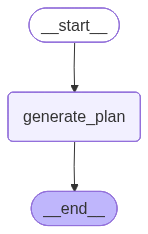

In [ ]:
graph_builder = StateGraph(ReportState)
graph_builder.add_node("generate_plan", generate_plan)
graph_builder.set_entry_point("generate_plan")
graph = graph_builder.compile()
graph

In [ ]:
state = {"topic": test_question}

config = RunnableConfig(
    configurable={
        "context": context,
        "report_organization": report_organization,
    }
)

# Run the graph
planner_result = graph.invoke(state, config=config)

pprint(planner_result["sections"][3])

Section(name='Infectious Disease Epidemiology in Displacement', description='Examination of communicable disease outbreaks in overcrowded shelters and disrupted healthcare settings', research=True, content='Outbreak surveillance data (diarrheal diseases, respiratory infections, vaccine-preventable diseases), water/sanitation infrastructure analysis, immunization program disruption, antimicrobial resistance patterns in field hospitals', audience_complexity='public_health_officials', estimated_length='standard', dependencies=['Nutritional Crisis and Growth Impacts'], success_criteria='Comprehensive disease burden assessment with transmission dynamics and prevention barrier identification')


# Write sections, but with context offloading

In [ ]:
class ScratchpadState(BaseModel):
    """State that includes conversation messages and a persistent scratchpad."""

    messages: Annotated[list[AnyMessage], add_messages]
    scratchpad: str = Field(
        default="",
        description="Persistent scratchpad for storing important context and notes",
    )


class WriteToScratchpad(BaseModel):
    """Write or append to the scratchpad for context retention"""

    notes: str = Field(description="The notes to write to the scratchpad")
    mode: Literal["append", "replace"] = Field(
        default="append",
        description="'append' adds to existing notes, 'replace' overwrites the existing notes",
    )


class ReadFromScratchpad(BaseModel):
    """Read context from scratchpad"""

    query: str = Field(
        default="all",
        description="What to look for in the scratchpad. Use 'all' for everything",
    )


class ClearScratchpad(BaseModel):
    """Clear the scratchpad to free up context"""

    confirm: bool = Field(
        description="Must be True to confirm the clearing of the scratchpad"
    )

In [ ]:
section_tools = [
    WriteToScratchpad,
    ReadFromScratchpad,
    ClearScratchpad,
    web_search,
    retriever_tool,
]
llm_with_tools = llm.bind_tools(section_tools)

# Create tool registry for easier lookup (map name -> tool object)
tool_by_name = {
    (tool.name if hasattr(tool, "name") else tool.__name__): tool
    for tool in section_tools
}

In [ ]:
def write_sections(state: SectionState):
    messages = state.get("messages", [])
    section = state["section"]
    scratchpad = state.get("scratchpad", "")
    scratchpad_file = state.get("scratchpad_file", "")

    if not scratchpad_file:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        section_slug = section.name.lower().replace(" ", "_")[:30]
        scratchpad_file = f"scratchpad_{section_slug}_{timestamp}.md"

    # tool_messages = [msg for msg in messages if isinstance(msg, ToolMessage)]

    if not messages:
        prompt = initial_research_prompt.format(
            name=section.name,
            description=section.description,
            content=section.content,
            audience_complexity=section.audience_complexity,
            estimated_length=section.estimated_length,
            dependencies=section.dependencies,
            success_criteria=section.success_criteria,
        )

        messages = [
            SystemMessage(content=section_writer_prompt),
            HumanMessage(content=prompt),
        ]

    elif scratchpad and not any("Phase 2" in str(m.content) for m in messages):
        synthesis_prompt = scratchpad_prompt.format(
            name=section.name,
            estimated_length=section.estimated_length,
            audience_complexity=section.audience_complexity,
            success_criteria=section.success_criteria,
            scratchpad=scratchpad,
        )

        messages = [
            SystemMessage(
                content="You are a medical report writer. Write the section content based on the provided notes. Do not use any tools."
            ),
            HumanMessage(content=synthesis_prompt),
        ]
        response = llm.invoke(messages)  # No tool calls
        section.content = response.content

        return {
            "messages": messages + [response],
            "completed_sections": [section],
            "scratchpad_file": scratchpad_file,
        }

    response = llm_with_tools.invoke(messages)
    if hasattr(response, "content") and not hasattr(response, "tool_calls"):
        section.content = response.content
        return {
            "messages": messages + [response],
            "completed_sections": [section],
            "scratchpad_file": scratchpad_file,
        }

    return {"messages": messages + [response], "scratchpad_file": scratchpad_file}

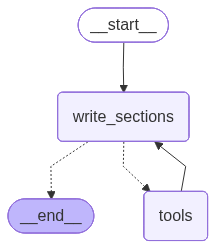

In [ ]:
section_graph = StateGraph(SectionState, output_schema=SectionStateOutput)
section_graph.add_node("write_sections", write_sections)
section_graph.add_node("tools", tool_node)
section_graph.add_conditional_edges(
    "write_sections", tools_condition, {"tools": "tools", "__end__": END}
)
section_graph.add_edge("tools", "write_sections")
section_graph.set_entry_point("write_sections")

section_builder = section_graph.compile()
display(Image(section_builder.get_graph().draw_mermaid_png()))

In [ ]:
planner_result["sections"][3]

Section(name='Infectious Disease Epidemiology in Displacement', description='Examination of communicable disease outbreaks in overcrowded shelters and disrupted healthcare settings', research=True, content='Outbreak surveillance data (diarrheal diseases, respiratory infections, vaccine-preventable diseases), water/sanitation infrastructure analysis, immunization program disruption, antimicrobial resistance patterns in field hospitals', audience_complexity='public_health_officials', estimated_length='standard', dependencies=['Nutritional Crisis and Growth Impacts'], success_criteria='Comprehensive disease burden assessment with transmission dynamics and prevention barrier identification')

In [ ]:
# section_state = SectionState(section=planner_result["sections"][0])
# section_writer_result = asyncio.run(section_builder.ainvoke(section_state))

In [ ]:
planner_result["sections"][0]

Section(name='Introduction: Pediatric Health Crisis in Gaza Conflict', description="Contextual overview of the Gaza conflict's impact on children's health, establishing scope and significance of the humanitarian emergency", research=False, content='Background on conflict timeline, demographic profile of affected children, healthcare system baseline pre-conflict, and methodological approach for evidence synthesis', audience_complexity='public_health_officials', estimated_length='brief', dependencies=[], success_criteria='Clear establishment of report scope, conflict context, and methodological transparency')

In [ ]:
# Markdown(section_writer_result["completed_sections"][0].content)

In [ ]:
class FinalInstructions(Signature):
    """
    # KNOWLEDGE
    You are an expert technical writer specializing in report synthesis with deep understanding of:
    - Information architecture: How readers process introductions vs. conclusions differently
    - Cognitive load management: Balancing density with clarity in constrained word counts
    - Strategic communication: Translating technical findings into actionable insights
    - Markdown best practices: Semantic heading hierarchy, table formatting, list design
    - Report types: Comparative analysis, literature reviews, technical assessments, policy briefs

    # EXPERIENCE
    You have crafted hundreds of report sections and know how to:
    - Hook readers immediately with problem statements or compelling questions
    - Synthesize disparate findings into coherent narratives
    - Design comparison tables that illuminate rather than overwhelm
    - Distinguish between conclusions that summarize vs. those that advance thinking
    - Maintain tonal consistency across technical and strategic elements
    - Judge when structural elements (tables/lists) add value vs. clutter

    # REQUIREMENTS

    ## Introduction Sections
    **Mandatory specifications:**
    - Heading: `#` (H1 in Markdown) with provided section title
    - Length: Exactly 50-100 words (strict enforcement)
    - Format: Pure prose—zero lists, tables, bullets, or structural elements
    - Citations: None required (this is framing, not evidence presentation)

    **Content must include:**
    1. **Hook** (1-2 sentences): The core problem, gap, opportunity, or question this report addresses
    2. **Stakes** (1-2 sentences): Why this matters now—implications for specific stakeholders
    3. **Scope signal** (1 sentence): What the report covers without detailed enumeration

    **Quality markers:**
    - First sentence grabs attention (avoid generic "This report examines...")
    - Uses accessible language—technical terms only if universally known
    - Creates forward momentum toward the main body
    - Zero preamble or meta-commentary about the writing process

    ## Conclusion/Summary Sections
    **Mandatory specifications:**
    - Heading: `##` (H2 in Markdown) with provided section title
    - Length: Exactly 100-150 words (strict enforcement)
    - Format: Synthesized prose with optional ONE structural element
    - Citations: None required (synthesis of already-cited material)

    **Content strategy—ADAPTIVE to report type:**

    **Type A: Comparative Reports** (when report contrasts 2+ options/approaches/contexts)
    - **REQUIRED**: Markdown comparison table
    - **Table design rules:**
      * 2-4 columns (criteria + options being compared)
      * 3-5 rows (key differentiators only—not exhaustive)
      * Cells contain specific insights from report, not generic descriptions
      * Use `|` syntax with proper alignment
    - **Post-table text** (30-50 words): Clear recommendation or "when to choose X vs. Y" guidance

    **Type B: Non-Comparative Reports**
    - **Optional structural element** (use only if it genuinely clarifies):
      * Insights table (2-3 rows, Markdown `|` syntax): When findings cluster into categories
      * Priority list (3-5 items, `-` or `1.` format): When recommendations have hierarchy
    - **Synthesis text** (100-150 words if no structure; 70-100 if using structure):
      * Cross-cutting themes that span multiple report sections
      * Specific next steps or implementation priorities
      * Forward-looking implications (research gaps, emerging trends, scenario planning)

    **Quality markers:**
    - References specific data, examples, or findings from the report (not generic claims)
    - Ends with clear directionality (next steps, decision criteria, or future outlook)
    - Structural elements (if used) are scannable and insight-dense
    - Zero summary-style repetition of what was already said

    # NUANCE

    **Judging when to use structural elements in conclusions:**
    - Use comparison table: When report explicitly evaluates 2+ alternatives and readers need decision support
    - Use insights table: When 3-4 major themes emerged that benefit from side-by-side comparison
    - Use priority list: When recommendations have clear rank order or sequencing
    - Use prose only: When synthesis is narrative/conceptual or findings are too interconnected to separate

    **Word count philosophy:**
    - These are constraints that force clarity, not targets to hit with filler
    - If you draft 110 words for an intro, cut the least essential 10—don't just stop mid-thought
    - Every word must earn its place through specificity or narrative necessity

    **Tone calibration:**
    - Introduction: Inviting but purposeful (balance accessibility with seriousness)
    - Conclusion: Authoritative and directive (this is where you guide the reader forward)
    - Both: Match the technical register of the full report (don't suddenly simplify or complexify)

    **Common pitfalls to avoid:**
    - Introductions that are actually abstracts (save the "what we found" for conclusions)
    - Conclusions that just restate section headings ("First we covered X, then Y...")
    - Tables with redundant rows or columns that don't differentiate meaningfully
    - Lists that are really just prose broken into bullets for no structural reason

    # EXPECTATIONS

    **Output format:**
    - Start immediately with the Markdown heading (no preamble like "Here's the introduction...")
    - Include ONLY the section content—no word counts, no explanations, no process notes
    - Proper Markdown syntax (heading levels, table formatting, list spacing)
    - Clean, publication-ready text with no formatting artifacts

    **Quality bar:**
    - A subject matter expert should find the introduction compelling enough to keep reading
    - A decision-maker should find the conclusion actionable enough to act on
    - Both sections should feel cohesive with the report's overall voice and depth
    - If you can remove a sentence without losing meaning, that sentence shouldn't exist

    **Success metrics:**
    - Introduction: Reader understands the "why read this" within 10 seconds
    - Conclusion: Reader leaves with 1-2 specific insights or next steps they didn't have before
    - Both: Zero generic language that could apply to any report on any topic

    # LIMITS

    **DO NOT:**
    - Include word counts or meta-commentary in your response
    - Exceed word limits (50-100 for intro, 100-150 for conclusion)—this is non-negotiable
    - Use structural elements in introductions (zero exceptions)
    - Use more than ONE structural element in conclusions
    - Write conclusions that merely summarize—they must synthesize or advance thinking
    - Reference sources by citation numbers (synthesis assumes report already cited sources)
    - Use vague language like "various factors," "multiple approaches," "recent studies" without specifics
    - Create tables with more than 5 rows or lists with more than 5 items (focus is key)
    - Begin with phrases like "This section will..." or "In conclusion..." (just write the content)
    - Include recommendations that weren't evidenced in the provided report context

    **Content boundaries:**
    - You can only synthesize what's in the provided context—do not introduce new claims
    - If context lacks comparative data but section_topic says "Conclusion," default to Type B format
    - If word count forces a choice, prioritize actionable insights over comprehensive coverage

    **Structural rules:**
    - Heading hierarchy is fixed: `#` for intro, `##` for conclusion (never `###` or other levels)
    - Tables must use standard Markdown pipe syntax with header row and alignment
    - Lists must have blank lines before/after for proper rendering
    - No nested lists or complex formatting (keep it simple and scannable)
    """

    section_title = InputField(
        desc="The exact title/heading for this section (will be used in Markdown heading)"
    )
    section_topic = InputField(
        desc="Section type ('Introduction' or 'Conclusion/Summary') and brief topic context. "
        "For conclusions, specify if report is comparative (requires comparison table)."
    )
    context = InputField(
        desc="Complete report content including all sections, findings, data, and examples. "
        "This is the sole source material for synthesis—include everything relevant."
    )

    section_content = OutputField(
        desc="The complete, publication-ready section starting with proper Markdown heading. "
        "No preamble, no word counts, no explanations—just the section content itself."
    )

In [ ]:
trauma = planner_result["sections"][1]
final_instruct = Predict(FinalInstructions)
stats = final_instruct(
    section_title=trauma.name, section_topic=trauma.description, context=""
)
Markdown(stats.section_content)

Children in conflict zones face devastating physical trauma that differs fundamentally from adult injury patterns. Their developing bodies and higher surface-area-to-volume ratios make them particularly vulnerable to blast injuries, with primary blast effects causing severe internal damage even without visible external wounds. Penetrating trauma from shrapnel often affects multiple organ systems simultaneously, while burns frequently cover larger body surface areas with deeper tissue destruction. Crush injuries present complex challenges due to children's more pliable skeletal structures. Treatment is systematically hindered by destroyed healthcare infrastructure, supply chain disruptions, and the specialized pediatric expertise required for these complex polytrauma cases, creating a cascade of preventable disability and mortality.

# Work in parallel

In [ ]:
def initiate_section_writing(state: ReportState):
    return [
        Send("build_section_with_tools", {"section": s})
        for s in state["sections"]
        if s.research
    ]


def write_final_sections(state: SectionState):
    section = state["section"]
    completed_sections = state.get("completed_sections_context", "")
    final_instructions = Predict(FinalInstructions)

    section_content = final_instructions(
        section_title=section.name,
        section_topic=section.description,
        context=completed_sections,
    ).section_content

    section.content = section_content
    return {"completed_sections": [section]}

In [ ]:
def gather_completed_sections(state: ReportState):
    completed_sections = state.get("completed_sections", [])
    return {"completed_sections_context": completed_sections}


def initiate_final_section_writing(state: ReportState):
    return [
        Send(
            "write_final_sections",
            {
                "section": s,
                "completed_sections_context": state["completed_sections_context"],
                "messages": [],
                "scratchpad": "",
            },
        )
        for s in state["sections"]
        if not s.research
    ]

In [ ]:
def compile_final_report(state: ReportState):
    sections = state["sections"]
    completed_sections = {s.name: s.content for s in state["completed_sections"]}

    for section in sections:
        section.content = completed_sections[section.name]

    # Compile final report
    all_sections = "\n\n".join([s.content for s in sections])
    return {"final_report": all_sections}

In [ ]:
builder = StateGraph(
    ReportState,
    input_schema=ReportStateInput,
    output_schema=ReportStateOutput,
    context_schema=ReportConfig,
)

builder.add_node("generate_report_plan", generate_plan)
builder.add_node("build_section_with_tools", section_graph.compile())
builder.add_node("gather_sections", gather_completed_sections)
builder.add_node("write_final_sections", write_final_sections)
builder.add_node("compile_final_report", compile_final_report)

# Trigger section building only via conditional Send() to ensure each task receives a 'section'
builder.add_conditional_edges(
    "generate_report_plan", initiate_section_writing, ["build_section_with_tools"]
)
# After building a section, gather it
builder.add_edge("build_section_with_tools", "gather_sections")
# For sections that don't require research, write them using accumulated context
builder.add_conditional_edges(
    "gather_sections",
    initiate_final_section_writing,
    ["write_final_sections"],
)
# Compile final report after writing final sections
builder.add_edge("write_final_sections", "compile_final_report")
builder.set_entry_point("generate_report_plan")

app = builder.compile()

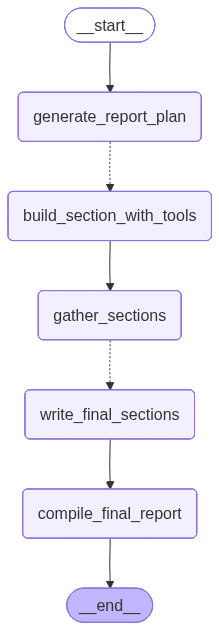

In [ ]:
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
report_topic = "Impact of the Gaza war on children"
initial_state = {"topic": report_topic}
report = asyncio.run(app.ainvoke(initial_state))

In [ ]:
Markdown(report["final_report"])